In [1]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

TEMPERATURE = 310*kelvin
FRICTION = 1/picosecond
TIMESTEP = 2*femtoseconds

SIGMA0 = (MOLAR_GAS_CONSTANT_R * TEMPERATURE ).value_in_unit(kilojoule_per_mole) * 10

# GaMD in OpenMM
The most convenient way to implement GaMD in OpenMM is using a custom integrator. In the custom integrator, the force has already been calculated by OpenMM. That means we can't edit the potential energy function and expect to re-calculate the force. Instead, we find out what the change in potential energy would have done to the force, and do the same thing within the integrator.  

Normally, the force is the negative of the gradient of the potential $V(\vec r)$:
$$f = -1 \left( \frac{\partial V(\vec r)}{\partial \vec r}\right)$$

In GaMD, we use a modified potential:

$$V'(\vec r) = V(\vec r) + dV(\vec r)$$ 

where:

$$dV(\vec r) = \frac{k}{2} (E - V(\vec r))^2$$

So the modified force is now:

$$f' = -1 \left( \frac{\partial V(\vec r) + \frac{k}{2} (E - V(\vec r))^2}{\partial \vec r}\right)$$

Separate into two derivatives with the Sum rule:

$$f' = - \left( \frac{\partial V(\vec r)}{\partial \vec r}\right) -  \left( \frac{\partial \frac{k}{2} (E - V(\vec r))^2 }{\partial \vec r}\right)  $$


Now to start simplifying. The left hand term is already $-f$ and we can move $\frac{k}{2}$ outside (Constant rule):

$$f' =  f -  \frac{k}{2} \left( \frac{\partial (E - V(\vec r))^2 }{\partial \vec r}\right)  $$

Expanding the right hand side:

$$f' =  f -  \frac{k}{2} \left( \frac{\partial (E^2 - 2EV(\vec r) + V(\vec r)^2) }{\partial \vec r}\right)  $$

$E^2$ is a constant and doesn't affect the derivative, so remove it:

$$f' =  f -  \frac{k}{2} \left( \frac{\partial ( - 2EV(\vec r) + V(\vec r)^2) }{\partial \vec r}\right)  $$

Factor out one of the $V(\vec r)$ terms so we can do a chain rule afterwards:

$$f' =  f -  \frac{k}{2} \left( \frac{\partial ( V(\vec r)(- 2E + V(\vec r)) }{\partial \vec r}\right)  $$

Now use the chain rule:

$$f' =  f -  \frac{k}{2} \left( \frac{\partial V(\vec r) }{\partial \vec r}\cdot(-2E + V(\vec r)) + \frac{\partial (-2E + V(\vec r)) }{\partial \vec r} \cdot V(\vec r) \right)  $$


This is where life gets easier. The left derivative is $-f$ again. The $-2E$ can be removed from the right derivative, since it's a constant, meaning the right derivative is just $-f$ as well!

$$f' = f - \frac{k}{2} \left( -f\cdot(-2E + V(\vec r)) -fV(\vec r) \right) $$

One step at a time...

$$f' = f - \frac{k}{2} \left( 2fE - fV(\vec r) -fV(\vec r) \right) $$

then 
$$f' = f - \frac{k}{2} \left( 2fE - 2fV(\vec r) \right) $$

then 
$$f' = f - \frac{k}{2} \left( 2f(E - V(\vec r)) \right) $$

then 
$$f' = f - fk \left( E - V(\vec r) \right) $$



So finally, we have the modified force being the original force multiplied by a factor of $k$, $E$, and $V(\vec r)$:

$$f' = f \cdot (1 - k(E - V(\vec r) )$$ 


----------------------------

The custom integrator below is a Langevin integrator with some extra parameters like $E$ and $k$ (one of each for the dihedrals force group, and one of each for everything else, which Miao et al. call 'total' potential), which are used to calculate the modified force. 

It also has methods to calculate the magnitude of the boost, which can be used later to re-weight the free energy estimates.  

In [2]:
class CustomGaMDLangevinIntegrator(CustomIntegrator):
    def __init__(self, temperature, friction, dt, ktot, Etot, kgrp, Egrp, forceGroup):
        self.ktot = ktot 
        self.Etot = Etot 
        self.kgrp = kgrp
        self.Egrp = Egrp
        self.forceGroup = str(forceGroup)
        
        CustomIntegrator.__init__(self, dt)
            #lew added:
        self.addGlobalVariable("ktot", self.ktot)
        self.addGlobalVariable("Etot", self.Etot)
        self.addGlobalVariable("kgrp", self.ktot)
        self.addGlobalVariable("Egrp", self.Egrp)
        self.addGlobalVariable("groupEnergy", 0)
        
            #normal langevin:  
        self.addGlobalVariable("temperature", temperature);
        self.addGlobalVariable("friction", friction);
        self.addGlobalVariable("vscale", 0);
        self.addGlobalVariable("fscale", 0);
        self.addGlobalVariable("noisescale", 0);
        self.addPerDofVariable("x0", 0);
        
        self.addPerDofVariable("fgrp", 0)
        
            #normal langevin:                                                                  
        self.addUpdateContextState();
        
        self.addComputeGlobal("groupEnergy", "energy"+self.forceGroup)
        self.addComputePerDof("fgrp", "f"+self.forceGroup)
        
        self.addComputeGlobal("vscale", "exp(-dt*friction)");
        self.addComputeGlobal("fscale", "(1-vscale)/friction");
        #original line:                
        self.addComputeGlobal("noisescale", "sqrt(kT*(1-vscale*vscale)); kT=0.00831451*temperature");
        self.addComputePerDof("x0", "x");
            #original langevin line:                                                                                      
        #self.addComputePerDof("v", "vscale*v + fscale*f/m + noisescale*gaussian/sqrt(m)");  
            #GaMD:
        dof_string = "vscale*v + fscale*fprime/m + noisescale*gaussian/sqrt(m);"
        dof_string+= "fprime= fprime1 + fprime2;"
        #fprime2 is the dihedral force modified by the boost. Boot calculated using group only. 
        dof_string+= "fprime2 = fgrp*((1-modifyGroup) + modifyGroup* (1 - kgrp*(Egrp - groupEnergy)) ) ;"
        #fprime1 is the other forces modified by the boost, but the boost is calculated using TOTAL energy. 
        dof_string+= "fprime1 = ftot*((1-modifyTotal) + modifyTotal* (1 - ktot*(Etot - energy)) );"
        
        dof_string+= "ftot=f-fgrp;"
        dof_string+= "modifyGroup=step(Egrp-groupEnergy);"
        dof_string+= "modifyTotal=step(Etot-energy);"
        self.addComputePerDof("v", dof_string); 
            #normal langevin                                            
        self.addComputePerDof("x", "x+dt*v");
        self.addConstrainPositions();
        self.addComputePerDof("v", "(x-x0)/dt");
        self.addComputePerDof("veloc", "v")
        
    def setKtot(self, newK):
        if not is_quantity(newK):
            newK = newK/kilojoules_per_mole
        self.setGlobalVariableByName('ktot', newK)
        
    def setEtot(self, newE):
        if not is_quantity(newE):
            newE = newE*kilojoules_per_mole
        self.setGlobalVariableByName('Etot', newE)
        
    def setKgrp(self, newK):
        if not is_quantity(newK):
            newK = newK/kilojoules_per_mole
        self.setGlobalVariableByName('kgrp', newK)
        
    def setEgrp(self, newE):
        #if not is_quantity(newE):
        #    newE = newE*kilojoules_per_mole
        #    print(newE)
        self.setGlobalVariableByName('Egrp', newE)
          
    def getGrpBoost(self, grpEnergy):
        kgrp = self.getGlobalVariableByName('kgrp')/kilojoules_per_mole
        Egrp = self.getGlobalVariableByName('Egrp')*kilojoules_per_mole
        if not is_quantity(grpEnergy):
            grpEnergy = grpEnergy*kilojoules_per_mole # Assume kJ/mole
        if (grpEnergy > Egrp):
            return 0*kilojoules_per_mole #no boosting
        return ( 0.5 * kgrp * (Egrp-grpEnergy)**2 ) # 'k' parameter should instead be per kj/mol
    
    def getTotBoost(self, totEnergy):
        ktot = self.getGlobalVariableByName('ktot')/kilojoules_per_mole
        Etot = self.getGlobalVariableByName('Etot')*kilojoules_per_mole
        if not is_quantity(totEnergy):
            totEnergy = totEnergy*kilojoules_per_mole # Assume kJ/mole
        if (totEnergy > Etot):
            return 0*kilojoules_per_mole #no boosting
        return ( 0.5 * ktot * (Etot-totEnergy)**2 ) # 'k' parameter should instead be per kj/mol
        
    def getEffectiveEnergy(self, totEnergy, grpEnergy):
        if not is_quantity(totEnergy):
            totEnergy = totEnergy*kilojoules_per_mole # Assume kJ/mole
        if not is_quantity(grpEnergy):
            grpEnergy = grpEnergy*kilojoules_per_mole # Assume kJ/mole
        
        group_boost = self.getGrpBoost(grpEnergy)
        total_boost = self.getTotBoost(totEnergy)
        
        return totEnergy + group_boost + total_boost
        
    



In [3]:
def setup_system(filename):
  """Creates a 'system' object given a pdb filename"""
  pdb = PDBFile(filename)
  forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')
  system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.CutoffPeriodic, constraints=HBonds,)
  system.addForce(MonteCarloBarostat(1*bar, 310*kelvin))
  set_dihedral_force_group(system)
  print('Created system')
  return system, pdb


def set_dihedral_force_group(system, g=2):
  """Sets the dihedral forcegroup to a number other than 0,
  which will be used by serial tempering"""
  print('Scanning forces:')
  for f in system.getForces():
    if isinstance(f, PeriodicTorsionForce):
      print('Found the torsions - setting group to 2')
      f.setForceGroup(2)
    print(f.getForceGroup(), f.__class__)

def setup_simulation(system, pdb, integrator):
  """Creates a simulation object"""
  #platform = Platform.getPlatformByName('CPU')
  platform = Platform.getPlatformByName('OpenCL')
  prop = {'OpenCLPrecision':'single'}
  simulation = Simulation(pdb.topology, system, integrator, platform, prop)
  simulation.context.setPositions(pdb.positions)
  simulation.minimizeEnergy()
  simulation.context.setVelocitiesToTemperature(310*kelvin)
  print('Created simulation')
  return simulation



In [4]:
filename ='./alanine-dipeptide-explicit.pdb'
output_directory = './'


In [5]:
system, pdb = setup_system(filename)



Scanning forces:
0 <class 'simtk.openmm.openmm.HarmonicBondForce'>
0 <class 'simtk.openmm.openmm.HarmonicAngleForce'>
Found the torsions - setting group to 2
2 <class 'simtk.openmm.openmm.PeriodicTorsionForce'>
0 <class 'simtk.openmm.openmm.NonbondedForce'>
0 <class 'simtk.openmm.openmm.CMMotionRemover'>
0 <class 'simtk.openmm.openmm.MonteCarloBarostat'>
Created system


In [6]:
integrator = CustomGaMDLangevinIntegrator(TEMPERATURE,
                                         FRICTION,
                                         TIMESTEP,
                                         1/kilojoules_per_mole,
                                         -1e6*kilojoules_per_mole, #set a ridiculous low threshold to start
                                         1/kilojoules_per_mole,
                                         -1e6*kilojoules_per_mole, #set a ridiculous low threshold to start
                                         2)

In [7]:
sim =setup_simulation(system, pdb, integrator)

Created simulation


In [8]:
#These functions help calculate the k and E parameters based on Miao's rules

def get_statistics(pe_trace, boost_trace=0):
    arr = np.array(pe_trace)
    arr = arr + np.array(boost_trace)
    Vmax = arr.max()
    Vmin = arr.min()
    Vavg = arr.mean()
    Vstd = np.std(arr)
    
    return [Vmax, Vmin, Vavg, Vstd]

def calc_parameters(Vmax, Vmin, Vavg, Vstd, mode='low', sigma_0=SIGMA0, verbose=False):
    E = Vmax
    k_0 = min(1, (sigma_0/Vstd) * ((Vmax-Vmin)/(Vmax-Vavg)))
    k = k_0 * (1 / (Vmax - Vmin) )
    
    if verbose:
        return E, k, k_0
    else:
        return E, k

# Collect some statistics from cMD:

In [9]:
grp_nrgs = list()
tot_nrgs = list()


for i in tqdm.tqdm_notebook(range(2000)):
    sim.step(100)
    
    grp_nrg = sim.context.getState(getEnergy=True, groups={2}).getPotentialEnergy()/kilojoule_per_mole
    tot_nrg = sim.context.getState(getEnergy=True).getPotentialEnergy()/kilojoule_per_mole
    
    grp_nrgs.append(grp_nrg)
    tot_nrgs.append(tot_nrg)
    
    

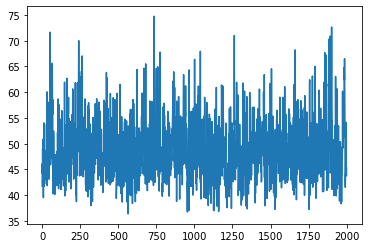

In [10]:
plt.plot(grp_nrgs)

# Initial estimate of k and E from the cMD run

In [11]:
#if doing total boost as well:
# Vmax, Vmin, Vavg, Vstd = get_statistics(tot_nrgs,0)
# E,k = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0=SIGMA0*10)
# sim.integrator.setEtot(E)
# sim.integrator.setKtot(k)

#for dihedral boost:
Vmax, Vmin, Vavg, Vstd = get_statistics(grp_nrgs, 0)
E,k = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0=SIGMA0*3)
print('Egrp:',E)
sim.integrator.setEgrp(E)
sim.integrator.setKgrp(k)

Egrp: 74.74067687988281


# Run iterative estimation of k, E parameters:

We have an estimate of the parameters from conventional MD above. Now we run short stints, continually updating those estimates based on the behaviour of the potential energy in response (for example, E is based on Vmax, thus will it gradually increase as the boost potential leads the system into higher energy regions of phase space). 

Eventually Vmax and Vstd, and thus k and E, should converge.

The below uses about 5 nanoseconds of simulation (there's also small equilibrations at the start of each step).

In [19]:
grp_nrgs = list()
tot_nrgs = list()

grp_boosts = list()
tot_boosts = list()

ks = list()
k_0s = list()
vmaxs = list()

gks = list()
gk_0s = list()
gvmaxs = list()

for _ in tqdm.tqdm_notebook(range(50)):
    #equil:
    sim.step(1000)
    
    for i in range(200):
        sim.step(250)
        
        grp_nrg = sim.context.getState(getEnergy=True, groups={2}).getPotentialEnergy()/kilojoules_per_mole
        tot_nrg = sim.context.getState(getEnergy=True,).getPotentialEnergy()/kilojoules_per_mole
        
        grp_boost = sim.integrator.getGrpBoost(grp_nrg)/kilojoule_per_mole
        tot_boost = sim.integrator.getTotBoost(tot_nrg)/kilojoule_per_mole
        
        grp_boosts.append(grp_boost)
        tot_boosts.append(tot_boost)
        
        grp_nrgs.append(grp_nrg)
        tot_nrgs.append(tot_nrg)
              
#In this example, I will only alter the dihedral boost
        
#     Vmax, Vmin, Vavg, Vstd = get_statistics(tot_nrgs, tot_boosts)
#     E,k,k_0 = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0 = SIGMA0*10,verbose=True)
#     sim.integrator.setEtot(E)
#     sim.integrator.setKtot(k)
    
#     ks.append(k)
#     k_0s.append(k_0)
#     vmaxs.append(E)
#     print(E, k, k_0)

    #smaller SIGMA0 for dihedrals group, i.e. below calculates up to an StdDev of 6kT :
    Vmax, Vmin, Vavg, Vstd = get_statistics(grp_nrgs, grp_boosts)
    E,k,k_0 = calc_parameters(Vmax, Vmin, Vavg, Vstd, sigma_0 = SIGMA0*6, verbose=True)
    sim.integrator.setEgrp(E)
    sim.integrator.setKgrp(k)
    
    gks.append(k)
    gk_0s.append(k_0)
    gvmaxs.append(E)
    print(E, k, k_0)

    

72.06260091871177 0.06225944620826417 1
82.09384155273438 0.038324366209415824 1
85.8898696899414 0.03345702565529297 1
88.64773559570312 0.030630728620655624 1
92.1520767211914 0.027661525982163704 1
92.1520767211914 0.027661525982163704 1
92.1520767211914 0.027661525982163704 1
92.1520767211914 0.027661525982163704 1
92.1520767211914 0.027661525982163704 1
92.73403930664062 0.027223286250288168 1
92.73403930664062 0.027223286250288168 1
93.76701354980469 0.026478680506730284 1
93.76701354980469 0.026478680506730284 1
94.07250213623047 0.026266214810875738 1
94.07250213623047 0.026266214810875738 1
100.96233367919922 0.022241224894151437 1
100.96233367919922 0.022241224894151437 1
100.96233367919922 0.022241224894151437 1
100.96233367919922 0.022241224894151437 1
100.96233367919922 0.022241224894151437 1
100.96233367919922 0.022241224894151437 1
100.96233367919922 0.022241224894151437 1
100.96233367919922 0.022241224894151437 1
100.96233367919922 0.022241224894151437 1
100.96233367919

Text(0.5, 1.0, 'Boost magnitude histogram\n(should be gaussian)')

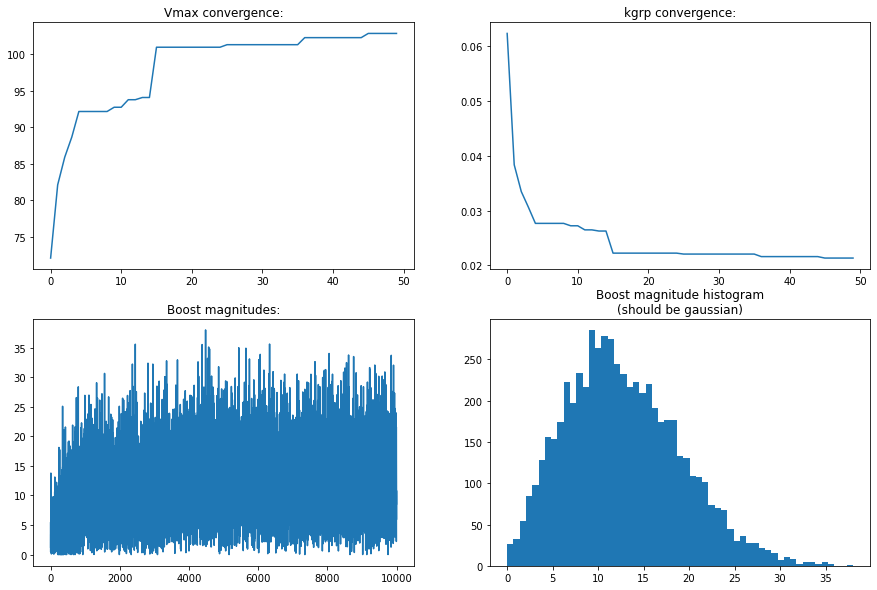

In [43]:
fig, ax = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(10)
ax[0,0].plot(gvmaxs)
ax[0,0].set_title('Vmax convergence:')

ax[0,1].plot(gks)
ax[0,1].set_title('kgrp convergence:')

ax[1,0].plot(grp_boosts)
ax[1,0].set_title('Boost magnitudes:')


ax[1,1].hist(grp_boosts[-6000:],bins=55)
ax[1,1].set_title('Boost magnitude histogram\n(should be gaussian)')

# Add a trajectory reporter and do some production run:


In [46]:

sim.reporters.append(DCDReporter('diala_gamd_traj.dcd', 150))

In [47]:
production = dict()
production['grp_nrgs'] = list()
production['tot_nrgs'] = list()

production['grp_boosts'] = list()
production['tot_boosts'] = list()

def report(sim, prod):
    grp_nrg = sim.context.getState(getEnergy=True, groups={2}).getPotentialEnergy()/kilojoules_per_mole
    tot_nrg = sim.context.getState(getEnergy=True,).getPotentialEnergy()/kilojoules_per_mole
        
    grp_boost = sim.integrator.getGrpBoost(grp_nrg)/kilojoule_per_mole
    tot_boost = sim.integrator.getTotBoost(tot_nrg)/kilojoule_per_mole
        
    prod['grp_boosts'].append(grp_boost)
    prod['tot_boosts'].append(tot_boost)
        
    prod['grp_nrgs'].append(grp_nrg)
    prod['tot_nrgs'].append(tot_nrg)
    

In [50]:
for _ in tqdm.tqdm_notebook(range(int(30*500000/150))): #30 nanoseconds
    report(sim, production)
    
    sim.step(150)

# Results.

Below shows the dihedral angles of so-called alanine dipeptide. We would expect, from conventional MD, to see on the order of 4 or 5 transitions into the 'rare' state over 1000ns. So far, simulating 30 nanoseconds, we see 9 or maybe 10 transitions already. We would expect probably an order of magnitude increase in sampling, so the boost that was used here might be a little bit too aggressive. The downside of this is that the boost probably isn't gaussian shaped enough despite having low standard deviation. This can be fixed with more careful equilibration.


In [51]:
import mdtraj as md
##the dihedral idices:
indices = np.array([[4, 6, 8, 14],[6, 8, 14, 16]])

traj = md.load_dcd('./diala_gamd_traj.dcd', top='./alanine-dipeptide-explicit.pdb')

dihedrals = md.compute_dihedrals(traj, indices, periodic=True)

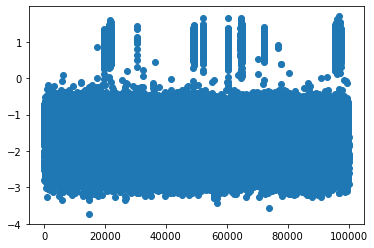

In [52]:
#slow moving dihedral:
plt.scatter(np.arange(len(dihedrals)), np.where(dihedrals[:,0]>2, dihedrals[:,0]-2*np.pi, dihedrals[:,0]))


0.08221536042910715

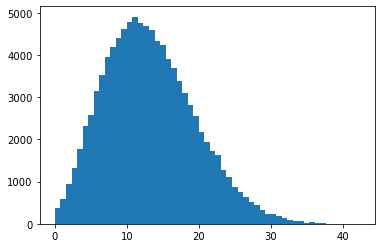

In [56]:
#boosts histogram - actually not too bad!
_=plt.hist(np.array(production['grp_boosts']), bins=55)


#using Miao's anharmonicity calculator:
def anharm(data):
    var=np.var(data)
    # hist, edges=np.histogram(data, 50, normed=True)
    hist, edges=np.histogram(data, 50, density=True)
    hist=np.add(hist,0.000000000000000001)  ###so that distrib
    dx=edges[1]-edges[0]
    S1=-1*np.trapz(np.multiply(hist, np.log(hist)),dx=dx)
    S2=0.5*np.log(np.add(2.00*np.pi*np.exp(1)*var,0.000000000000000001))
    alpha=S2-S1
    if np.isinf(alpha):
       alpha = 100
    return alpha


anharm(grp_boosts) #come to think of it, 0.08 might not be great.


/home/lewis/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


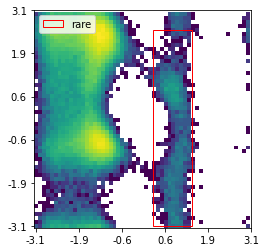

In [55]:
#Probability density of the boosted trajectory:

a,b,c = np.histogram2d(dihedrals[:,0], dihedrals[:,1], bins=55)

import matplotlib.patches as patches


fig, ax = plt.subplots(1)
ax.imshow(np.log(a).T, origin='lower')


# Create a Rectangle patch
rect = patches.Rectangle((30,0),10,50,linewidth=1,edgecolor='r',facecolor='none', label='rare')

# Add the patch to the Axes
ax.add_patch(rect)
ax.legend()

num_ticks = 6
_ =ax.set_xticks(np.linspace(0,55, num_ticks))
_ = ax.set_xticklabels([str(i) for i in np.around(np.linspace(-np.pi, np.pi, num_ticks),1)])
_ =ax.set_yticks(np.linspace(0,55, num_ticks))
_ = ax.set_yticklabels([str(i) for i in np.around(np.linspace(-np.pi, np.pi, num_ticks),1)])